In [34]:
%matplotlib inline

-------------------------------------  --------  ---------  ---------  ----------  ----------  ----------  -----------  -----------  -----------  ------------  --------  --------  --------
Algorithm / Size                       10        30         60         100         300         600         1000         3000         6000         10000         30000     60000     100000
Insertion sort                          1.1e-05   7.9e-05    0.000157    0.000391    0.003572    0.016242     0.044566     0.407506     1.65726       4.76415   N/A       N/A       N/A
Optimized merge sort                    6.1e-05   0.000144   0.000296    0.00054     0.001665    0.003992     0.006071     0.022915     0.048134      0.080431  0.266045  0.552744  0.997828
Optimized merge sort with insertion     1.3e-05   5.6e-05    0.000195    0.000528    0.001858    0.004546     0.00715      0.026827     0.049663      0.081133  0.255861  0.541216  0.996199
3-way merge sort                        7.6e-05   0.000259   0

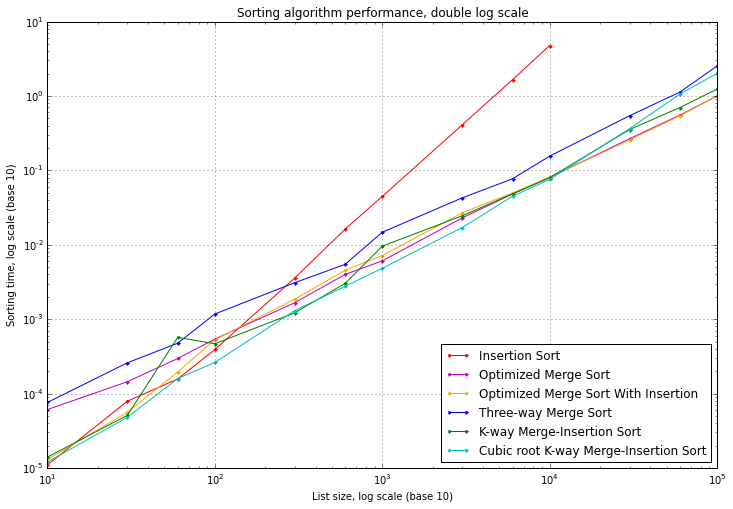

In [46]:
from profilehooks import profile
from numpy import random, average
import pstats
import os
import tabulate
import matplotlib.pyplot as plt

# A global flag to set of debug statements should be printed to stdout or not
DEBUG = False
# A path for profiling outputs
PROFILE_STATS_PATH = '/tmp/profile.stats'


def compare_gt(input_list, a, b):
    """
    Comparison of two places in a list extracted to a function.
    Used in order to profile how many times this comparison happens
    :param input_list: the list to check in
    :param a: the first index
    :param b: the second index
    :return: True if the item at a is larger than the item at b, false otherwise
    """
    return input_list[a] > input_list[b]


def swap(input_list, a, b):
    """
    Swapping two places in a list extracted to a function
    :param input_list: the list to check in
    :param a: the first index
    :param b: the second index
    :return: No return value; values in the list swapped places
    """
    temp = input_list[a]
    input_list[a] = input_list[b]
    input_list[b] = temp


def is_sorted(input_list):
    """
    Helper function to test if a list is already sorted
    :param input_list: the list to test
    :return: True if it is already sorted, false otherwise
    """
    return all(input_list[i] <= input_list[i + 1] for i in xrange(len(input_list) - 1))


@profile(sort='calls', immediate=True, stdout=False, filename=PROFILE_STATS_PATH)
def profiled_insertion_sort(input_list, start=0, end=None):
    """
    Insertion sort, implemnted from pseudo code by Cormen et al. (CLRS). Assumes the list isn't already sorted.

    A copy of the other insertion sort method, to use when profiling, in order to allow for cleaner printing
    of profiling outcomes (one profiled function calling another does not print neatly)

    :param input_list: the list to sort
    :param start: the index to start from, defaults to 0
    :param end: the index to end on, defaults to the length of the list, exclusive (Python list convention)
    :return: None, with the list sorted in-place
    """
    list_length = len(input_list)

    if end is None:
        end = list_length

    # start+1 as a list of length 1 is always sorted
    for i in xrange(start + 1, end):
        current_value = input_list[i]
        j = i - 1

        while (j >= start) and (input_list[j] > current_value):
            input_list[j + 1] = input_list[j]
            j -= 1

        input_list[j + 1] = current_value


def insertion_sort(input_list, start=0, end=None):
    """
    Insertion sort, implemnted from pseudo code by Cormen et al. (CLRS). Assumes the list isn't already sorted.
    :param input_list: the list to sort
    :param start: the index to start from, defaults to 0
    :param end: the index to end on, defaults to the length of the list, exclusive (Python list convention)
    :return: None, with the list sorted in-place
    """
    list_length = len(input_list)

    if end is None:
        end = list_length

    # start+1 as a list of length 1 is always sorted
    for i in xrange(start + 1, end):
        current_value = input_list[i]
        j = i - 1

        while (j >= start) and (input_list[j] > current_value):
            input_list[j + 1] = input_list[j]
            j -= 1

        input_list[j + 1] = current_value


@profile(sort='calls', immediate=True, stdout=False, filename=PROFILE_STATS_PATH)
def k_way_merge_sort(input_list, k=3, start=0, end=None, insertion_sort_threshold=None):
    """
    Fully flexible k-way merge sort. Default value of k=3 makes it a three-way
    merge sort unless a different parameter is passed in.
    :param input_list: The list to sort, assumes it is not already sorted.
    :param k: The number of sub-arrays to sort and merge through every time.
            k > len(input_list) will be treated as len(input_list), k < 1 will be treated as k = 1,
            which is actually insertion sort, so it will call insertion sort directly
    :param start: the start index of the subarray currently being processed
            defaults to 0, to allow ignoring the parameter when calling on the whole array
    :param end: the end index of the subarray currently being processed, exclusive (Python list convention)
            defaults to the length of the list to allow ignoring when calling on the whole array
    :param insertion_sort_threshold: The threshold under which to call insertion sort rather than merge.
            defaults to None, which will mean never.
    :return: None, with the list sorted in-place
    """
    list_length = len(input_list)

    if k > list_length:
        k = list_length

    if end is None:
        end = list_length

    # if k <= 1, we treat it as k = 1, which is insertion sort, so we just call that instead
    # Additionally, checks the insertion sort threshold, where below a certain list length we just use insertion sort
    if (k <= 1) or ((insertion_sort_threshold is not None) and (end - start <= insertion_sort_threshold)):
        return insertion_sort(input_list, start, end)

    # If the current subarray is smaller than k, just merge it directly, otherwise split it
    subarray_indices = generate_subarrays(start, end, k)
    if subarray_indices:
        for (subarray_start, subarray_end) in subarray_indices:
            k_way_merge_sort(input_list, k, subarray_start, subarray_end, insertion_sort_threshold)

    k_way_merge(input_list, start, end, subarray_indices)


def generate_subarrays(start, end, k):
    """
    Generate subarray indices for given start index, end index, and k parts.
    Attempts to generate subarrays of as equal length as possible.
    Once it finds a size that evenly divides the remaining part into the remaining number of subarrays,
    stops dividing each time to find the current size, and uses the stable one.
    
    This could be optimized even again, by performing the modulo once and knowing that we have 
    ((end - start) % k) "longer" subarrays, whose length is one more than the regular length, which
    is floor((end - start) / k)
    
    :param start: the start index of the the current subarray to divide
    :param end: the end index of the the current subarray to divide, exclusive (Python list convention)
    :param k: the number of subarrays to divide to.
    :return: If k < end - start, divides into k subarrays of as equal length as possible
            Otherwise, returns None
    """
    if DEBUG:
        print 'subarrays called, start={start}, end={end}, k={k}'.format(start=start, end=end, k=k)

    if not (end - start > k):
        return None

    subarray_indices = []
    stable_size = None

    for i in xrange(k):
        if stable_size:
            current_end = start + stable_size
            subarray_indices.append((start, current_end))

        else:
            current_subarray_size = (end - start) / (k - i)
            mod = ((end - start) % (k - i))
            if 0 == mod:
                stable_size = current_subarray_size

            current_end = start + current_subarray_size
            subarray_indices.append((start, current_end))

        start = current_end

    if DEBUG:
        print subarray_indices

    return subarray_indices


def k_way_merge(input_list, start, end, subarray_indices):
    """
    Merge the subarrays in the section between start and end. Deals with several edge cases:
    - If there's one element, do nothing (one element is always sorted)
    - If there are two elements, swap them if necessary
    - If all "subarrays" are all of length 1, treat it as insertion sort (and call it instead)
    - Otherwise, actually merge the subarrays
    :param input_list: The list to merge in
    :param start: The index the subarrays start in
    :param end: The index the subarrays end in, exclusive (Python list convention)
    :param subarray_indices: The indices of the different subarrays in the interval [start, end),
                            each assumed to be sorted.
    :return: None, with the section of input_list between start and end sorted
    """
    if DEBUG:
        print 'merge called, start={start}, end={end}, subarrays={subarray_indices}'.format(
            start=start, end=end, subarray_indices=subarray_indices)

    # If there's only one element, there is nothing to do
    if start + 1 == end:
        return

    # If there are two elements, they might need to be swapped
    if start + 2 == end:
        if compare_gt(input_list, start, end - 1):
            swap(input_list, start, end - 1)
        return

    # If there are no subarray indices, we're merging "lists" of length 1, which is equivalent to insertion sort:
    if subarray_indices is None:
        insertion_sort(input_list, start, end)
        return

    # the more complicated case, of merging actual sub-lists
    sub_lists = [input_list[start_index: end_index] for (start_index, end_index) in subarray_indices]

    for index in xrange(start, end):
        min_sub_list_index = 0
        for current_sub_list_index in xrange(1, len(sub_lists)):
            if sub_lists[current_sub_list_index][0] < sub_lists[min_sub_list_index][0]:
                min_sub_list_index = current_sub_list_index

        input_list[index] = sub_lists[min_sub_list_index].pop(0)
        if not sub_lists[min_sub_list_index]:
            sub_lists.pop(min_sub_list_index)

    if DEBUG:
        print input_list


@profile(sort='calls', immediate=True, stdout=False, filename=PROFILE_STATS_PATH)
def merge_sort(input_list, start=0, end=None, insertion_sort_threshold=None):
    """
    My original merge sort implementation, optimized for two sublists at a given time -
    which is particularly relevant during merging.
    
    Added an insertion-sort threshold to this implementation as well, to see if it can
    beat out the non-naive one.
    
    :param input_list: The list to be sorted in-place, assumed not to be sorted already.
    :param start: Optional, the starting index. If omitted assumed to be 0.
    :param end: Optional, the end index. If omitted assumed to be len(input_list).
                Thus, it is always treated as open-ended, and never included in the sort.
    :return: None, with the list sorted between start and end
    """
    if end is None:
        end = len(input_list)

    if DEBUG:
        print 'merge sort called, start={start}, end={end}'.format(start=start, end=end)

    if (insertion_sort_threshold is not None) and (end - start <= insertion_sort_threshold):
        insertion_sort(input_list, start, end)
        return
        
    # Adding two as it's an open-ended interval
    mid = None
    if start + 2 < end:
        mid = start + (end - start) / 2
        merge_sort(input_list, start, mid)
        merge_sort(input_list, mid, end)

    merge(input_list, start, mid, end)


def merge(input_list, start, mid, end):
    """
    The original merge implementation, optimized for merging two-sublists.
    :param input_list: The list to merge in.
    :param start: The index to start from
    :param mid: The index of the middle - if it does not exist, assumed to be a slice of length 1 or 2.
    :param end: The index to end at, open-ended - not included in merging.
    """
    if DEBUG:
        print 'merge called, start={start}, mid={mid}, end={end}'.format(start=start, mid=mid, end=end)

    # The degenerate case - "merging" a list of length 1
    if start + 1 == end:
        return

    # The less-degenerate case - potentially swapping two elements
    if mid is None:
        if input_list[start] > input_list[end - 1]:
            swap(input_list, start, end - 1)

    # The "real" case, of merging two sub-lists, at least one of whom is longer than one.
    else:
        new_sub_list = []
        left_index = start
        right_index = mid
        while (left_index < mid) or (right_index < end):
            if (left_index == mid) or (right_index != end and input_list[left_index] > input_list[right_index]):
                new_sub_list.append(input_list[right_index])
                right_index += 1

            else:
                new_sub_list.append(input_list[left_index])
                left_index += 1

        input_list[start:end] = new_sub_list


def k_way_function_params(input_list, k_function, threshold_function):
    length = len(input_list)
    k_way_merge_sort(input_list, k=k_function(length), insertion_sort_threshold=threshold_function(length))


def optimization_function(params, training_set):
    """
    A function designed to attempt to optimize parameters for the insertion-sort threshold variant of
    k-way merge sort. Ended up using it to brute force through parameters. It calculates the time taken
    for every collection to sort in the training set, and returns the average time
    :param params: The parameters to pass to k_way_merge_sort - assumed to be (k, insertion_sort_threshold)
    :param training_set: An iterable of collections to sort (by default a list of lists)
    :return: The average time taken to sort every collection in the training set
    """
    results = []
    k, insertion_sort_threshold = params

    for test_list in training_set:
        k_way_merge_sort(test_list, k=int(k), insertion_sort_threshold=int(insertion_sort_threshold))
        results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)

    avg = average(results)

    if DEBUG:
        print k, insertion_sort_threshold, avg
    return avg


def various_testing_routines():
    """
    A number of various testing routines developed while checking implementations
    :return: None
    """
    # Stress / random testing code:
    # for i in xrange(100):
    #     if 0 == (i % 10):
    #         print i
    #
    #     for k in xrange(2, 21):
    #         ints = [i for i in random.random_integers(0, 1000, 1000)]
    #         ints_copy = ints[:]
    #         k_way_merge_sort(ints_copy, k=k)
    #
    #         if not is_sorted(ints_copy):
    #             print ints
    #             print ints_copy
    #             print k

    # More exhaustion testing, this time of all possible values of k
    # for k in xrange(1000):
    #     ints = [i for i in random.random_integers(0, 1000, 1000)]
    #     ints_copy = ints[:]
    #     k_way_merge_sort(ints, k=k)
    #
    #     if not is_sorted(ints):
    #         print k
    #         print ints_copy
    #         print ints

    # More exhaustion testing, this time for values of the insertion sort threshold
    # for threshold in xrange(2, 100):
    #     ints = [i for i in random.random_integers(0, 1000, 1000)]
    #     ints_copy = ints[:]
    #     k_way_merge_sort(ints, insertion_sort_threshold=threshold)
    #
    #     if not is_sorted(ints):
    #         print threshold
    #         print ints_copy
    #         print ints

    # ints = [i for i in random.random_integers(0, 10000, 10000)]
    # profiled_insertion_sort(ints)
    # k_way_merge_sort(ints[:], k=10)
    # k_way_merge_sort(ints[:], k=10, insertion_sort_threshold=10)

    return


def brute_force_parameter_search():
    """
    Perform brute force searches in attempt to find optimal parameters for the insertion-sort optimized merge sort.
    First search performed was a wide search over 2-100 in jumps of five, and the second one was a narrower one,
    in the range [10, 30, 2]x[30, 60, 3] for k and the insertion sort threshold.

    I attempted to perform more complex optimization routines, but they are problematic for at least three reasons:
    1) There's no guarantee the average running time is convex - there could clearly be local optima.
    2) Measuring time is not necesarily a good proxy, as it might depends on other OS processes and scheduling issues
    (e.g., it is unclear to me if time measured is while this process is running, or globally). Number of function calls
    is also a flawed measure, as the recursive implementation of merge sort makes it take many more calls than insertion
     sort. The number of CPU cycles required would likely give a better measure.
    3) The parameters are integer-valued, which makes optimizing them far more annoying than a scalar-valued function.
     I looked into linear/integer programming for a few minutes, and decided to eschew it for now due to reasons 1 and 2.
    :return: None
    """

    training_set = [list(random.random_integers(0, 10000, random.randint(100, 10000))) for _ in xrange(20)]

    # min_k = 0
    # min_threshold = 0
    # min_average = 1
    # first search - wide search over some intervals - seemed to suggest k { [10, 25], thresh ~ 900
    # for k in xrange(2, 32, 10):
    #     for threshold in xrange(2, 2002, 100):
    #         print k, threshold
    #         avg = optimization_function((k, threshold), training_set)
    #         if avg < min_average:
    #             min_average = avg
    #             min_k = k
    #             min_threshold = threshold
    #
    # print 'First search, [2, 101, 5] x [2, 101, 5]', min_k, min_threshold, min_average

    min_k = 0
    min_threshold = 0
    min_average = 1

    # second search - narrow search over k in [6, 26, 2], threshold in [800, 1000, 20]  -
    for k in xrange(6, 26, 2):
        for threshold in xrange(800, 1001, 20):
            avg = optimization_function((k, threshold), training_set)
            print k, threshold, avg
            if avg < min_average:
                min_average = avg
                min_k = k
                min_threshold = threshold

    print 'Second search, [6, 26, 2] x [800, 1000, 20]', min_k, min_threshold, min_average


# Values selected after running the brute force parameter search several times
# for randomly generated list sizes between 100 and 10000
FINAL_K = 22  # 10
FINAL_THRESHOLD = 33  # 1000
LIST_SIZES = (10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000, 60000, 100000,)
INSERTION_SORT_MAX = 10000


def performance_graphs():
    insertion_sort_results = []
    merge_sort_results = []
    merge_sort_with_threshold_results = []
    three_way_results = []
    k_way_with_threshold_results = []
    k_way_func_params_results = []

    for size in LIST_SIZES:
        if DEBUG:
            print 'Current size', size

        current_list = [i for i in random.random_integers(0, 10000, size)]

        if size <= INSERTION_SORT_MAX:
            profiled_insertion_sort(current_list[:])
            insertion_sort_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
            os.remove(PROFILE_STATS_PATH)

        merge_sort(current_list[:])
        merge_sort_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)
        
        merge_sort(current_list[:], insertion_sort_threshold=100)
        merge_sort_with_threshold_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)

        k_way_merge_sort(current_list[:])
        three_way_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)

        k_way_merge_sort(current_list[:], k=FINAL_K, insertion_sort_threshold=FINAL_THRESHOLD)
        k_way_with_threshold_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)

        k_way_function_params(current_list[:], lambda l: int(l ** 0.33), lambda l: 33)
        k_way_func_params_results.append(pstats.Stats(PROFILE_STATS_PATH).total_tt)
        os.remove(PROFILE_STATS_PATH)

    print(tabulate.tabulate([["Algorithm / Size"] + list(LIST_SIZES),
                             ["Insertion sort"] + insertion_sort_results + ['N/A'] * 3,
                             ["Optimized merge sort"] + merge_sort_results,
                             ["Optimized merge sort with insertion"] + merge_sort_with_threshold_results,
                             ["3-way merge sort"] + three_way_results,
                             ["k-way merge sort with insertion"] + k_way_with_threshold_results,
                             ["k-way with cubic root k and insertion"] + k_way_func_params_results, ]))

    plt.figure(figsize=(12, 8), dpi=400)

    plt.loglog(LIST_SIZES[:10], insertion_sort_results, basex=10, basey=10, c='r', marker='.', 
               label='Insertion Sort')
    plt.loglog(LIST_SIZES, merge_sort_results, basex=10, basey=10, c='m', marker='.', 
               label='Optimized Merge Sort')
    plt.loglog(LIST_SIZES, merge_sort_with_threshold_results, basex=10, basey=10, c='#ffa500', marker='.', 
               label='Optimized Merge Sort With Insertion')    
    plt.loglog(LIST_SIZES, three_way_results, basex=10, basey=10, c='b', marker='.', 
               label='Three-way Merge Sort')
    plt.loglog(LIST_SIZES, k_way_with_threshold_results, basex=10, basey=10, c='g', marker='.',
               label='K-way Merge-Insertion Sort')
    plt.loglog(LIST_SIZES, k_way_func_params_results, basex=10, basey=10, c='c', marker='.',
               label='Cubic root K-way Merge-Insertion Sort')

    plt.grid(True)
    plt.title("Sorting algorithm performance, double log scale")
    plt.xlabel("List size, log scale (base 10)")
    plt.ylabel("Sorting time, log scale (base 10)")
    plt.legend(loc='lower right')

    plt.show()


def main():
    performance_graphs()


if __name__ == '__main__':
    main()

In [51]:
print """
In case the result table is unclear:

Algorithm / Size                       10        30         60         100         300         600         1000 
Insertion sort                         1.1e-05   7.9e-05    0.000157   0.000391    0.003572    0.016242    0.044566  
Optimized merge sort                   6.1e-05   0.000144   0.000296   0.00054     0.001665    0.003992    0.006071  
Optimized merge sort with insertion    1.3e-05   5.6e-05    0.000195   0.000528    0.001858    0.004546    0.00715
3-way merge sort                       7.6e-05   0.000259   0.000475   0.001174    0.003091    0.005452    0.014729
k-way merge sort with insertion        1.4e-05   5.1e-05    0.000569   0.000467    0.001218    0.003025    0.009579
k-way with cubic root k and insertion  1.2e-05   4.8e-05    0.000159   0.000262    0.001304    0.002762    0.004832

Algorithm / Size                       3000         6000         10000         30000     60000     100000
Insertion sort                         0.407506     1.65726      4.76415       N/A       N/A       N/A
Optimized merge sort                   0.022915     0.048134     0.080431      0.266045  0.552744  0.997828
Optimized merge sort with insertion    0.026827     0.049663     0.081133      0.255861  0.541216  0.996199
3-way merge sort                       0.042654     0.076954     0.155215      0.542322  1.126882  2.528289
k-way merge sort with insertion        0.024486     0.048351     0.079612      0.353529  0.698736  1.235374
k-way with cubic root k and insertion  0.016994     0.044912     0.075738      0.363328  1.060603  2.016468

Note: I find it very neat that the merge sort variants are an order of magnitude better than insertion sort 
at these sizes - insertion sort handles 10k entries in ~4 seconds, while all merge sort variants handle 100k
in less time. It is also a good example of why algortihm choice is crucial - the performance benfits of all
merge sort variants are reasonably close to each other.
"""


In case the result table is unclear:

Algorithm / Size                       10        30         60         100         300         600         1000 
Insertion sort                         1.1e-05   7.9e-05    0.000157   0.000391    0.003572    0.016242    0.044566  
Optimized merge sort                   6.1e-05   0.000144   0.000296   0.00054     0.001665    0.003992    0.006071  
Optimized merge sort with insertion    1.3e-05   5.6e-05    0.000195   0.000528    0.001858    0.004546    0.00715
3-way merge sort                       7.6e-05   0.000259   0.000475   0.001174    0.003091    0.005452    0.014729
k-way merge sort with insertion        1.4e-05   5.1e-05    0.000569   0.000467    0.001218    0.003025    0.009579
k-way with cubic root k and insertion  1.2e-05   4.8e-05    0.000159   0.000262    0.001304    0.002762    0.004832

Algorithm / Size                       3000         6000         10000         30000     60000     100000
Insertion sort                         0.4

In [47]:
print """
Discussion:

For small array sizes, up until ~100 elements, insertion sort seems to win out. This makes sense, as the 
recursive implementation of merge sort has some overhead via function calls, which insertion sort manages
to avoid. However, after that point insertion sort gets bad and worse. Interestingly, the "naive" (two-way)
merge sort shows the best performance, probably as its merging behavior is optimized and requires far less
looping. I also suspect that the naive optimization parameter search (for k and the insertion threshold,
see the function brute_force_parameter_search) is flawed, or behaves differently between execution in 
PyCharm and in the Jupyer Notebook. The parameters suggested by it (k ~= 10, threhsold ~= 1000) perform 
worse when graphed here than the ones currently showcased (k=22, threshold=33).

The cubic-root variant was borne out of an idea that might give both the better performance of the naive 
three-way merge sort for smaller arrays while still gaining the performance bonuses for larger values. 
It currently serves as some sort of middle ground, even outperforming both until n ~= 10000; I am sure 
it could be optimized further, but as discussed in the comments to optimization_function, this optimization
would be untrivial. 

As one final idea, I tried combining the insertion sort threshold with the optimized two-way merge sort. 
Any performance benefits were neligeble, but the results were left in the graph and table above.

There is no best variant; only most suited for specific needs. If ease of implementation is a factor,
or if all lists being sorted are very small (n < 100), insertion sort takes the cake. Need a solid sort to
run once or twice on larger data? Merge sort will serve well. The larger the data, and the more critical 
the performance demands, the greated the edge it will deliver will be, either via the optimized 
implementation of two-way merge sort or by finding good k and threshold.

The notebook is available here: 
https://github.com/guydav/minerva/blob/master/cs110/k_way_merge_sort_notebook.ipynb

And the code in a python file here: 
https://github.com/guydav/minerva/blob/master/cs110/k_way_mergesort.py
"""


Discussion:

For small array sizes, up until ~100 elements, insertion sort seems to win out. This makes sense, as the 
recursive implementation of merge sort has some overhead via function calls, which insertion sort manages
to avoid. However, after that point insertion sort gets bad and worse. Interestingly, the "naive" (two-way)
merge sort shows the best performance, probably as its merging behavior is optimized and requires far less
looping. I also suspect that the naive optimization parameter search (for k and the insertion threshold,
see the function brute_force_parameter_search) is flawed, or behaves differently between execution in 
PyCharm and in the Jupyer Notebook. The parameters suggested by it (k ~= 10, threhsold ~= 1000) perform 
worse when graphed here than the ones currently showcased (k=22, threshold=33).

The cubic-root variant was borne out of an idea that might give both the better performance of the naive 
three-way merge sort for smaller arrays while still gaining